ADF Statistic: 0.3557114372339485
p-value: 0.9797609814934907
Selected differencing order d = 1


<Figure size 1000x400 with 0 Axes>

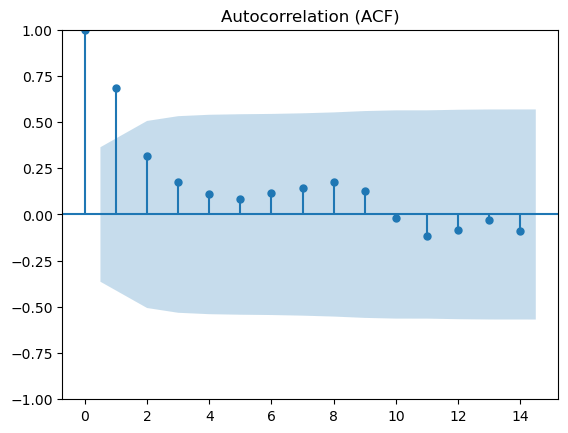

<Figure size 1000x400 with 0 Axes>

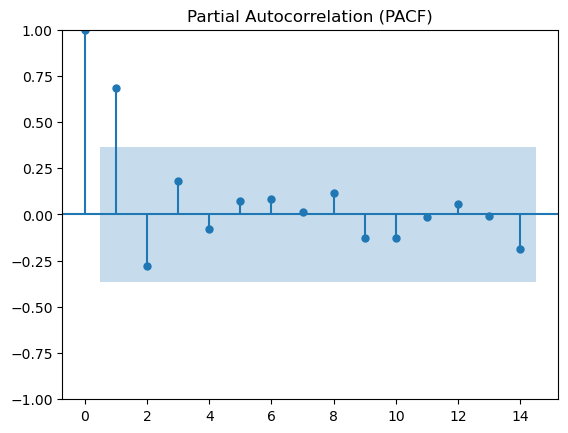

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("C:/Cardiofocus_revenue.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

series = pd.to_numeric(df['Revenue'], errors='coerce').interpolate()

# ---- ADF Test ----
adf_res = adfuller(series)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])
d = 0 if adf_res[1] < 0.05 else 1
print("Selected differencing order d =", d)

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = len(series) // 2
if max_lag < 1:
    max_lag = 1

plt.figure(figsize=(10, 4))
plot_acf(series, lags=max_lag)
plt.title("Autocorrelation (ACF)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(series, lags=max_lag, method='ywm')
plt.title("Partial Autocorrelation (PACF)")
plt.show()


In [3]:
#finding ADF statistics and p value
from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(series)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])
d = 0 if adf_res[1] < 0.05 else 1   # differencing order
print("Selected d =", d)



ADF Statistic: 0.3557114372339485
p-value: 0.9797609814934907
Selected d = 1


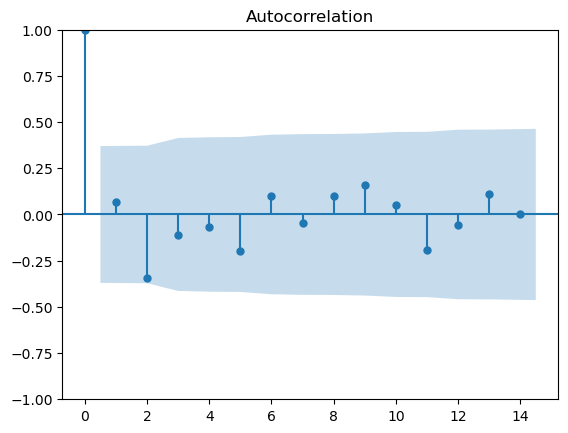

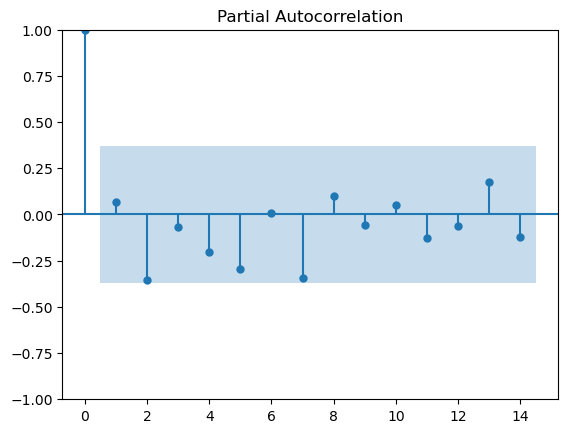

In [4]:
#autocorrelation
max_lag = len(series) // 2
max_lag = max(max_lag, 1)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series.diff(d).dropna(), lags=max_lag)
plt.show()
plot_pacf(series.diff(d).dropna(), lags=max_lag, method="ywm")
plt.show()


In [5]:
#finding best ARIMA order
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = q = range(0, 3)   # 0,1,2 choices
pdq = list(itertools.product(p, [d], q))  # differencing fixed

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = SARIMAX(series, order=order)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print("Best ARIMA order:", best_order, "| AIC:", best_aic)


Best ARIMA order: (0, 1, 2) | AIC: 26.34932015107896


In [6]:
#finding best sarima seasonal order
m = 12   # change if quarterly=4, weekly=52, daily=7/365

P = D = Q = range(0, 2)  # 0 or 1
seasonal_pdq = list(itertools.product(P, [0,1], Q))  # include D search

best_aic_s = float("inf")
best_seasonal = None
best_sarima = None

for (P, D, Q) in seasonal_pdq:
    try:
        model = SARIMAX(series, order=best_order, seasonal_order=(P, D, Q, m))
        results = model.fit(disp=False)
        if results.aic < best_aic_s:
            best_aic_s = results.aic
            best_seasonal = (P, D, Q, m)
            best_sarima = results
    except:
        continue

print("Best SARIMA seasonal order:", best_seasonal, "| AIC:", best_aic_s)


Best SARIMA seasonal order: (1, 1, 0, 12) | AIC: 23.446410290730828


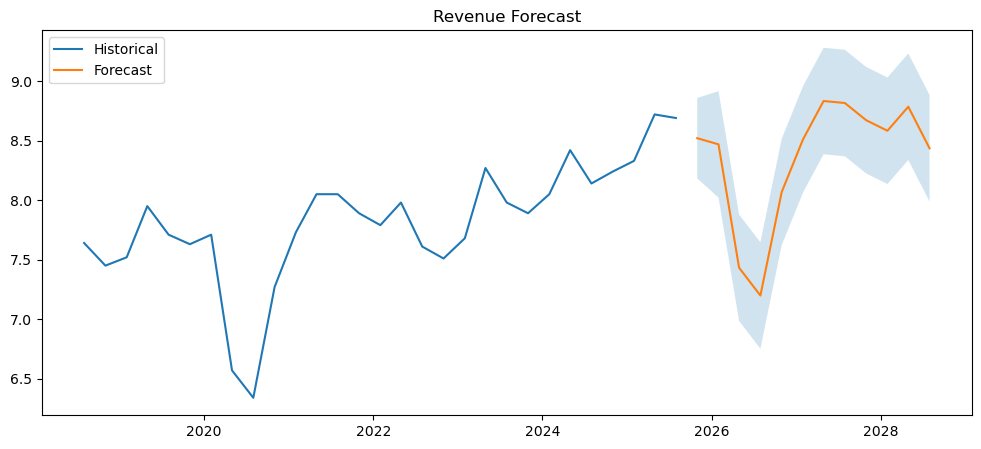

In [7]:
#ploting revenue forecast
final_model = best_sarima if best_sarima else best_model

forecast_steps = 12
forecast = final_model.get_forecast(steps=forecast_steps)
pred = forecast.predicted_mean
ci = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(series, label="Historical")
plt.plot(pred, label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.title("Revenue Forecast")
plt.show()


In [8]:
print("Best ARIMA order:", best_order)
print("Best SARIMA seasonal order:", best_seasonal)


Best ARIMA order: (0, 1, 2)
Best SARIMA seasonal order: (1, 1, 0, 12)


In [9]:
#printing forecast values
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit final SARIMA model
model = SARIMAX(series, order=(0, 1, 2), seasonal_order=(1, 1, 0, 12))
fit = model.fit()

# Forecasting future values
forecast_steps = 12   # next 12 months
forecast = fit.forecast(steps=forecast_steps)

print(forecast)


2025-10-31    8.520503
2026-01-31    8.468801
2026-04-30    7.432348
2026-07-31    7.198757
2026-10-31    8.067706
2027-01-31    8.509750
2027-04-30    8.832742
2027-07-31    8.815983
2027-10-31    8.671545
2028-01-31    8.582918
2028-04-30    8.784888
2028-07-31    8.435239
Freq: QE-OCT, Name: predicted_mean, dtype: float64


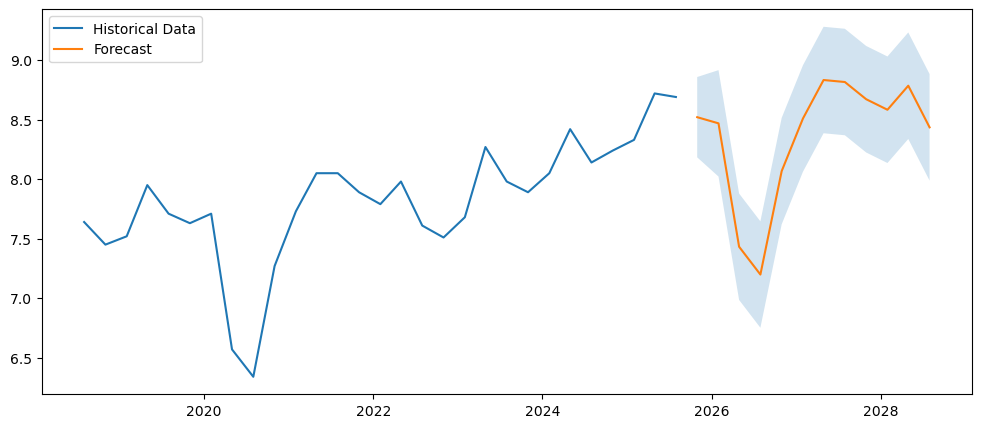

In [10]:
#ploting historical and forecast data
pred = fit.get_forecast(steps=forecast_steps)
mean_forecast = pred.predicted_mean
conf_int = pred.conf_int()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(series, label='Historical Data')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.2)

plt.legend()
plt.show()


In [59]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Cardiofocus_revenue.csv")

# Rename for convenience based on user input
date_col = "Date"
value_col = "Revenue"

# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col])

# Sort by date
df = df.sort_values(date_col)

# Compute Month-over-Month (MoM) growth
df["MoM_growth"] = df[value_col].pct_change() * 100

# Compute Year-over-Year (YoY) growth (12 months)
df["YoY_growth"] = df[value_col].pct_change(12) * 100

# Fill NaN growth with 0
df["MoM_growth"] = df["MoM_growth"].fillna(0)
df["YoY_growth"] = df["YoY_growth"].fillna(0)

# Save updated dataset 
df.to_csv("Cardiofocus_revenue_growth.csv", index=False)
print("Saved in the same folder where your notebook/code is located")

print(df.head())

df = df.copy()


# ---------- PREPARE DATA----------
df = df.copy()

# Auto-detect date column by trying to convert each column to datetime
date_col = None
for col in df.columns:
    try:
        pd.to_datetime(df[col])
        # If conversion works for >50% rows, treat it as date column
        if pd.to_datetime(df[col], errors='coerce').notna().mean() > 0.5:
            date_col = col
            break
    except:
        pass

if date_col is None:
    raise ValueError("No date-like column found — run print(df.columns) and tell me which one is the date column")

print(f"Detected date column: {date_col}")

# Convert to datetime & set index
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)
df = df.set_index(date_col)

# Target & regressor variables
y = df['Revenue'].astype(float)
exog = df[['MoM_growth', 'YoY_growth']].astype(float)


Saved in the same folder where your notebook/code is located
        Date  Revenue  MoM_growth  YoY_growth
0 2018-07-31     7.64    0.000000         0.0
1 2018-10-31     7.45   -2.486911         0.0
2 2019-01-31     7.52    0.939597         0.0
3 2019-04-30     7.95    5.718085         0.0
4 2019-07-31     7.71   -3.018868         0.0
Detected date column: Date


In [61]:

train_y, train_exog = y, exog

# ---------- MODEL DEFINITION ----------
order = (0, 1, 2)
seasonal_order = (1, 1, 0, 12)  # as discovered earlier (seasonal period=12 for monthly; for quarterly data you'd use 4)

seasonal_period = 12
# detect approximate frequency: if index freq is quarterly, set seasonal_period=4
if getattr(train_y.index, "freqstr", None) and 'Q' in train_y.index.freqstr:
    seasonal_period = 4
elif len(train_y) >= 8 and (train_y.index.inferred_freq and 'Q' in train_y.index.inferred_freq):
    seasonal_period = 4
else:
    # default to 12 (matches your earlier run which used months)
    seasonal_period = 12

# use seasonal_order adjusted:
seasonal_order = (1, 1, 0, seasonal_period)

print(f"Using SARIMAX order={order} seasonal_order={seasonal_order} (seasonal period={seasonal_period})")


Using SARIMAX order=(0, 1, 2) seasonal_order=(1, 1, 0, 4) (seasonal period=4)


In [62]:
# Fit SARIMAX
model = SARIMAX(
    train_y,
    exog=train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   29
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 4)   Log Likelihood                   4.264
Date:                            Sat, 22 Nov 2025   AIC                              3.472
Time:                                    14:39:49   BIC                              9.447
Sample:                                07-31-2018   HQIC                             4.639
                                     - 07-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MoM_growth     0.0357      0.004      8.555      0.000       0.028       0.044
YoY_growth     0.0092      0.009   

In [65]:
# ---------- FORECAST / PREDICTION ----------
horizon = 12  # forecast next 12 quarters

last_index = train_y.index[-1]

# Prepare future exogenous regressors...
if 'exog_future' in globals():
    ...
else:
    lookback = min(4, len(train_exog))
    fallback_vals = train_exog.iloc[-lookback:].mean(axis=0)
    exog_fc = pd.DataFrame([fallback_vals.values] * horizon, columns=train_exog.columns)
    print("No exog_future provided — using mean of last %d rows repeated for forecasting." % lookback)


No exog_future provided — using mean of last 4 rows repeated for forecasting.


In [66]:
#finding exogeneous variable 
if 'exog_future' in globals():
    exog_fc = exog_future.copy().reset_index(drop=True).astype(float)
    if len(exog_fc) < horizon:
        raise ValueError("exog_future provided but has fewer rows than horizon.")
else:
    # fallback: compute mean of last up to 4 observed rows, then repeat
    lookback = min(4, len(train_exog))
    fallback_vals = train_exog.iloc[-lookback:].mean(axis=0)
    exog_fc = pd.DataFrame([fallback_vals.values] * horizon, columns=train_exog.columns)
    print("No exog_future provided — using mean of last %d rows repeated for forecasting." % lookback)

# Create forecast index depending on train frequency
if getattr(train_y.index, "freq", None) is not None:
    # Use same freq to create future index
    future_index = pd.date_range(start=train_y.index[-1] + train_y.index.freq, periods=horizon, freq=train_y.index.freq)
else:
    # If no explicit freq, assume quarterly steps (Q) and create quarterly periods
    future_index = pd.date_range(start=last_index + pd.offsets.QuarterEnd(), periods=horizon, freq='Q')

exog_fc.index = future_index


No exog_future provided — using mean of last 4 rows repeated for forecasting.


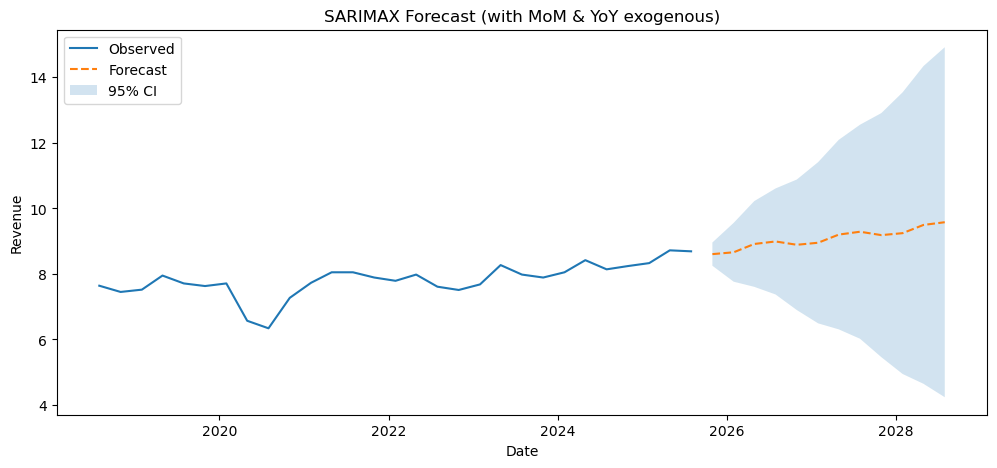

In [67]:
# Forecast
pred_res = res.get_forecast(steps=horizon, exog=exog_fc)
pred_mean = pred_res.predicted_mean
pred_ci = pred_res.conf_int()

# ---------- PLOT ----------
plt.figure(figsize=(12,5))
# plot history
plt.plot(train_y.index, train_y, label='Observed')
# plot forecast mean
plt.plot(pred_mean.index, pred_mean, label='Forecast', linestyle='--')
# plot confidence interval
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 alpha=0.2, label='95% CI')
plt.legend()
plt.title('SARIMAX Forecast (with MoM & YoY exogenous)')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()


In [68]:
# ---------- SAVE FORECASTS ----------
out = pd.DataFrame({
    'Date': pred_mean.index,
    'predicted_mean': pred_mean.values,
    'ci_lower': pred_ci.iloc[:,0].values,
    'ci_upper': pred_ci.iloc[:,1].values
})
# attach exog used for each forecast row (optional)
for col in exog_fc.columns:
    out[col] = exog_fc[col].values

# Save to CSV in current working directory
out_file = "sarimax_forecast_with_exog.csv"
out.to_csv(out_file, index=False)
print(f"Forecast saved to: {os.path.abspath(out_file)}")

# ---------- OPTIONAL: Print coefficients significance ----------
coef_table = pd.DataFrame({
    'coef': res.params,
    'std_err': res.bse,
    'z': res.params / res.bse,
    'pvalue': res.pvalues
})
print("\nCoefficient table (coef, stderr, z, pvalue):\n", coef_table)


Forecast saved to: C:\Users\Dell\OneDrive\souju jupyter\INTERNSHIP\sarimax_forecast_with_exog.csv

Coefficient table (coef, stderr, z, pvalue):
                 coef      std_err         z        pvalue
MoM_growth  0.035714     0.004175  8.554949  1.179210e-17
YoY_growth  0.009198     0.009143  1.006026  3.144030e-01
ma.L1       1.375329  3353.944419  0.000410  9.996728e-01
ma.L2       0.375349  1258.802403  0.000298  9.997621e-01
ar.S.L4    -0.403570     0.157510 -2.562193  1.040136e-02
sigma2      0.031170   104.543207  0.000298  9.997621e-01


In [69]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [74]:

# ---- Train-Test Split ----
train = df.iloc[:-12]   # last 12 months for testing
test = df.iloc[-12:]

y_train = train['Revenue']
y_test = test['Revenue']
exog_train = train[['MoM_growth', 'YoY_growth']]
exog_test = test[['MoM_growth', 'YoY_growth']]

results = []
def evaluate_model(name, model_fit, forecast):
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mape = mean_absolute_percentage_error(y_test, forecast) * 100
    results.append({
        "Model": name,
        "AIC": model_fit.aic,
        "BIC": model_fit.bic,
        "RMSE": rmse,
        "MAPE (%)": mape
    })
    print(f"\n{name}:\nRMSE = {rmse:.3f}, MAPE = {mape:.3f}%, AIC = {model_fit.aic:.2f}, BIC = {model_fit.bic:.2f}")
    
# ---------------- ARIMA ----------------
arima = ARIMA(y_train, order=(0,1,2)).fit()
arima_forecast = arima.forecast(steps=12)
evaluate_model("ARIMA(0,1,2)", arima, arima_forecast)


# ---------------- SARIMA ----------------
sarima = SARIMAX(y_train, order=(0,1,2), seasonal_order=(1,1,0,12)).fit()
sarima_forecast = sarima.get_forecast(steps=12).predicted_mean
evaluate_model("SARIMA(0,1,2)(1,1,0,12)", sarima, sarima_forecast)


# ---------------- ARIMAX ----------------
arimax = ARIMA(y_train, order=(0,1,2), exog=exog_train).fit()
arimax_forecast = arimax.forecast(steps=12, exog=exog_test)
evaluate_model("ARIMAX(0,1,2)+growth", arimax, arimax_forecast)


# ---------------- SARIMAX ----------------
sarimax = SARIMAX(y_train, order=(0,1,2), seasonal_order=(1,1,0,12), exog=exog_train).fit()
sarimax_forecast = sarimax.get_forecast(steps=12, exog=exog_test).predicted_mean
evaluate_model("SARIMAX(0,1,2)(1,1,0,12)+growth", sarimax, sarimax_forecast)


# ---- Results DataFrame ----
performance_df = pd.DataFrame(results)
print("\n\n===== Model Performance Comparison =====")
print(performance_df.sort_values(by="RMSE"))



ARIMA(0,1,2):
RMSE = 0.692, MAPE = 7.400%, AIC = 18.13, BIC = 20.45

SARIMA(0,1,2)(1,1,0,12):
RMSE = 0.932, MAPE = 8.880%, AIC = 0.64, BIC = -1.81

ARIMAX(0,1,2)+growth:
RMSE = 0.418, MAPE = 4.295%, AIC = 8.58, BIC = 12.44

SARIMAX(0,1,2)(1,1,0,12)+growth:
RMSE = 0.228, MAPE = 1.956%, AIC = -19.30, BIC = -22.98


===== Model Performance Comparison =====
                             Model        AIC        BIC      RMSE  MAPE (%)
3  SARIMAX(0,1,2)(1,1,0,12)+growth -19.302536 -22.984770  0.228298  1.956148
2             ARIMAX(0,1,2)+growth   8.576110  12.439053  0.417676  4.294534
0                     ARIMA(0,1,2)  18.127757  20.445523  0.692080  7.399641
1          SARIMA(0,1,2)(1,1,0,12)   0.641881  -1.812941  0.931679  8.879929


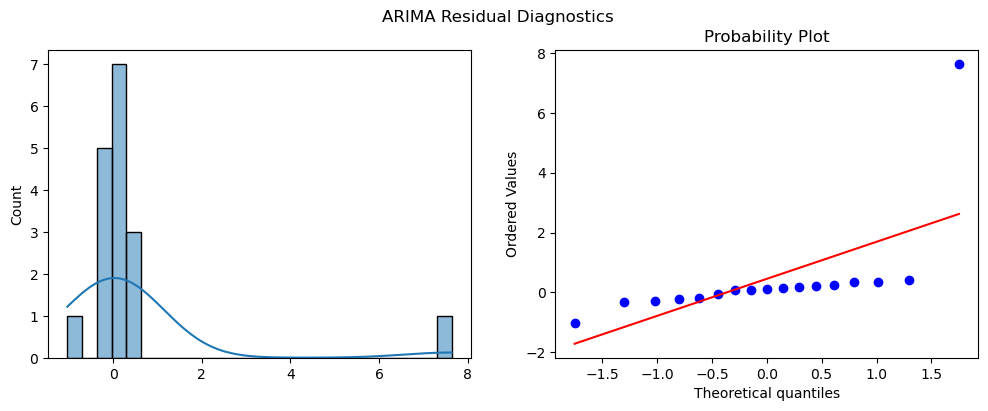

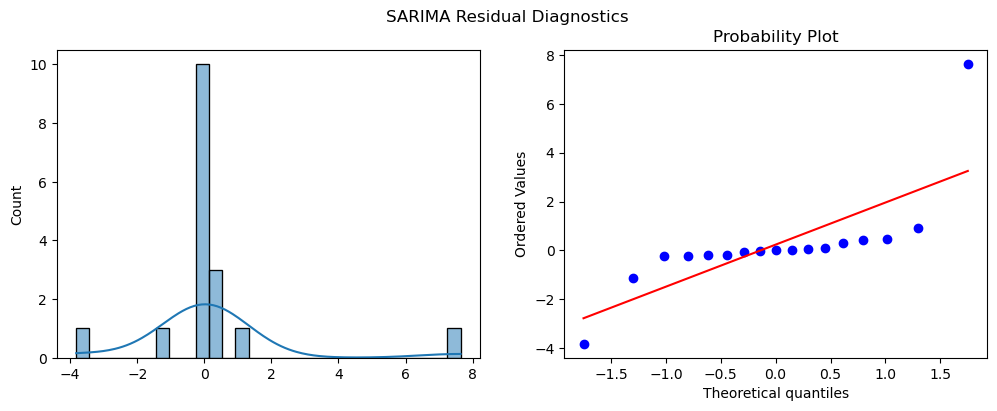

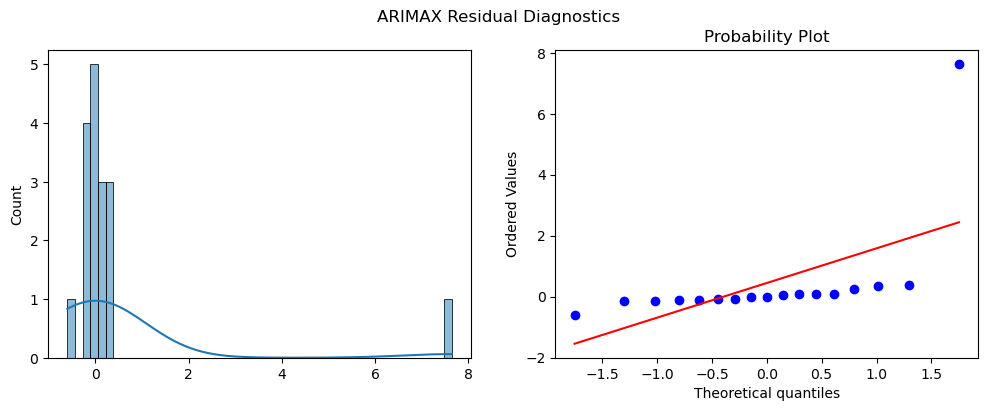

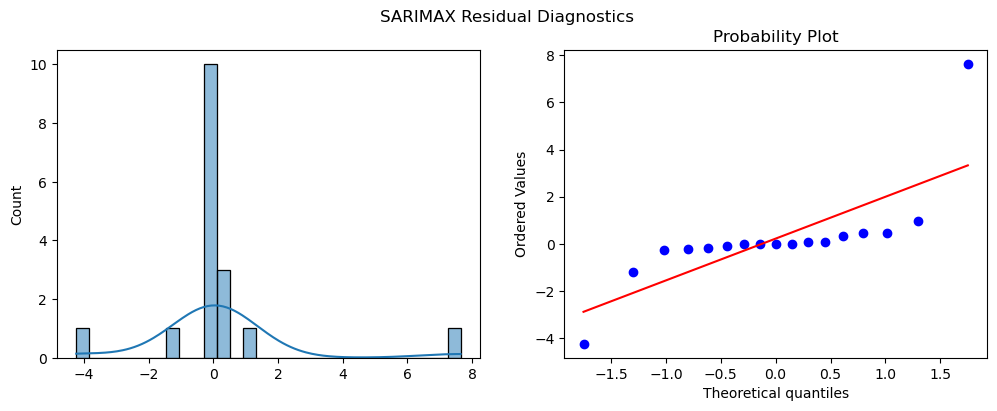

In [75]:
import seaborn as sns
import scipy.stats as stats

models = {
    "ARIMA": arima,
    "SARIMA": sarima,
    "ARIMAX": arimax,
    "SARIMAX": sarimax
}

for name, m in models.items():
    res = m.resid
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(res, kde=True, ax=ax[0])
    stats.probplot(res, plot=ax[1])
    plt.suptitle(f"{name} Residual Diagnostics")
    plt.show()


In [76]:
coef_table = pd.DataFrame({
    'coef': sarimax.params,
    'std_err': sarimax.bse,
    'z': sarimax.params / sarimax.bse,
    'pvalue': sarimax.pvalues
})
print(coef_table)


                coef       std_err           z    pvalue
MoM_growth -0.002268  4.134735e-02   -0.054854  0.956255
YoY_growth  0.075338  5.273600e-02    1.428591  0.153122
ma.L1       0.000013  2.710317e+00    0.000005  0.999996
ma.L2       0.000003  5.510476e-01    0.000005  0.999996
ar.S.L12   -0.000004  6.127727e-09 -678.335333  0.000000
sigma2      0.000023  6.568693e-05    0.355366  0.722316


In [77]:
# Sort by RMSE (or MAPE) to pick the best model
best_model_info = performance_df.sort_values(by="RMSE").iloc[0]
best_model_name = best_model_info['Model']
print(f"Best Model: {best_model_name}")


Best Model: SARIMAX(0,1,2)(1,1,0,12)+growth


In [80]:
# Example future exogenous data for 12 quarters
exog_future = pd.DataFrame({
    'MoM_growth': [0.5, 0.3, 0.4, 0.2, 0.3, 0.4, 0.5, 0.2, 0.3, 0.4, 0.5, 0.3],
    'YoY_growth': [2.0, 1.8, 2.1, 2.0, 1.9, 2.2, 2.0, 1.8, 2.1, 2.0, 2.2, 2.1]
})


In [82]:
# Fit SARIMAX on full dataset
sarimax_full = SARIMAX(df['Revenue'],
                        order=(0,1,2),
                        seasonal_order=(1,1,0,12),
                        exog=df[['MoM_growth','YoY_growth']]).fit()

# Forecast next 12 quarters using exog_future
forecast_res = sarimax_full.get_forecast(steps=12, exog=exog_future)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Create future index (quarterly)
future_index = pd.date_range(start=df.index[-1] + pd.offsets.QuarterEnd(),
                             periods=12, freq='Q')

# Forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': future_index,
    'Forecast': forecast_mean.values,
    'CI_lower': forecast_ci.iloc[:,0].values,
    'CI_upper': forecast_ci.iloc[:,1].values
})

print(forecast_df)


         Date  Forecast  CI_lower  CI_upper
0  2025-09-30  7.924149  7.869457  7.978840
1  2025-12-31  7.993949  7.904402  8.083496
2  2026-03-31  7.278435  7.182060  7.374810
3  2026-06-30  7.211068  7.108317  7.313818
4  2026-09-30  8.065740  7.956988  8.174493
5  2026-12-31  8.292878  8.178438  8.407319
6  2027-03-31  8.590514  8.470655  8.710372
7  2027-06-30  8.764748  8.639706  8.889790
8  2027-09-30  8.714174  8.584154  8.844194
9  2027-12-31  8.611791  8.476978  8.746604
10 2028-03-31  8.766839  8.627397  8.906281
11 2028-06-30  8.482781  8.338859  8.626703


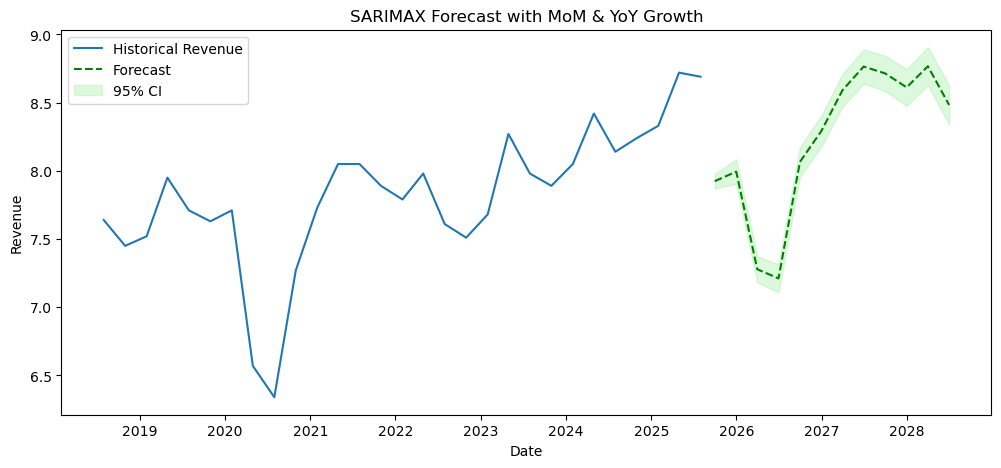

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Revenue'], label='Historical Revenue')
plt.plot(future_index, forecast_mean, linestyle='--', color='green', label='Forecast')
plt.fill_between(future_index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='lightgreen', alpha=0.3, label='95% CI')
plt.title("SARIMAX Forecast with MoM & YoY Growth")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()


In [84]:
# Convert results list to DataFrame
performance_df = pd.DataFrame(results)

# Sort by RMSE for easy comparison
performance_df = performance_df.sort_values(by="RMSE")
print("\n===== Model Performance Comparison =====")
print(performance_df)



===== Model Performance Comparison =====
                             Model        AIC        BIC      RMSE  MAPE (%)
3  SARIMAX(0,1,2)(1,1,0,12)+growth -19.302536 -22.984770  0.228298  1.956148
2             ARIMAX(0,1,2)+growth   8.576110  12.439053  0.417676  4.294534
0                     ARIMA(0,1,2)  18.127757  20.445523  0.692080  7.399641
1          SARIMA(0,1,2)(1,1,0,12)   0.641881  -1.812941  0.931679  8.879929


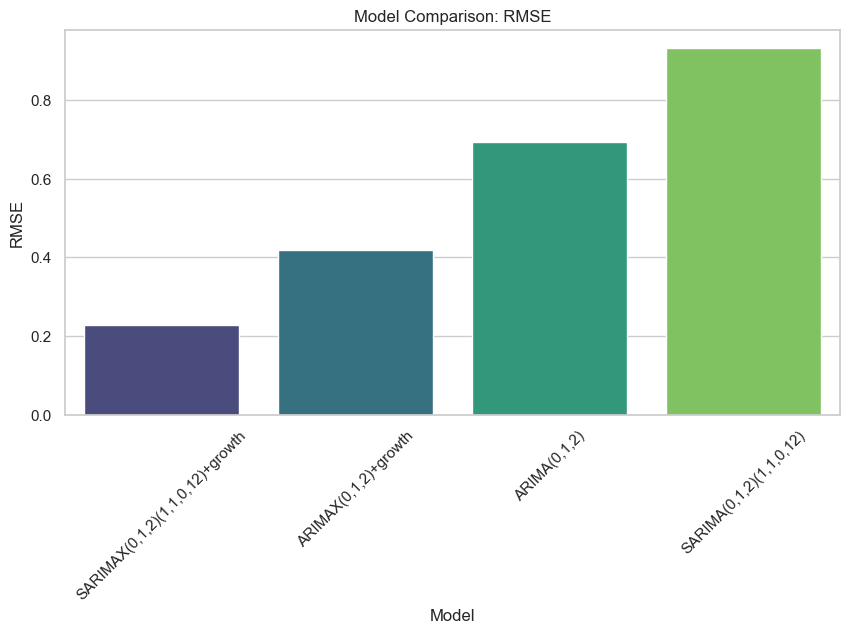

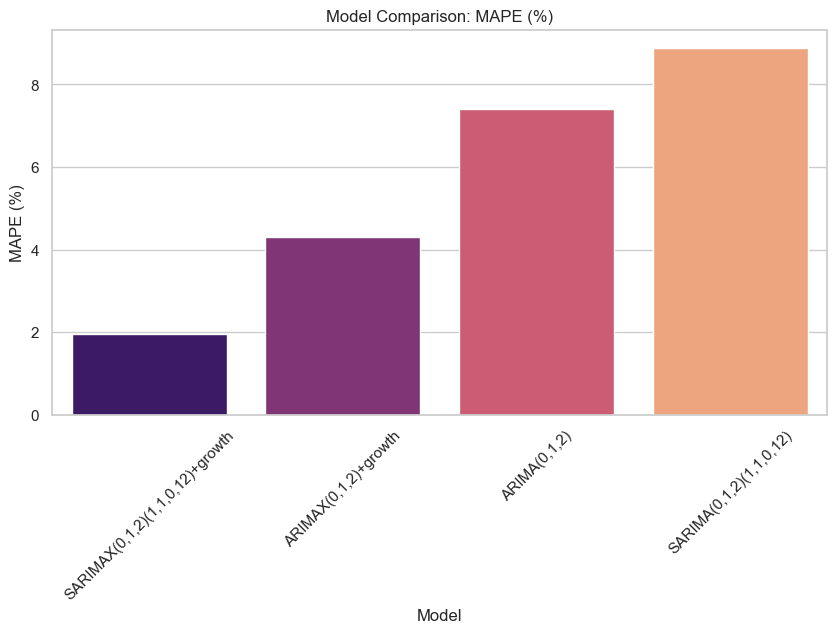

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot RMSE comparison
plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='RMSE', data=performance_df, palette="viridis")
plt.title("Model Comparison: RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

# Plot MAPE comparison
plt.figure(figsize=(10,5))
sns.barplot(x='Model', y='MAPE (%)', data=performance_df, palette="magma")
plt.title("Model Comparison: MAPE (%)")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=45)
plt.show()


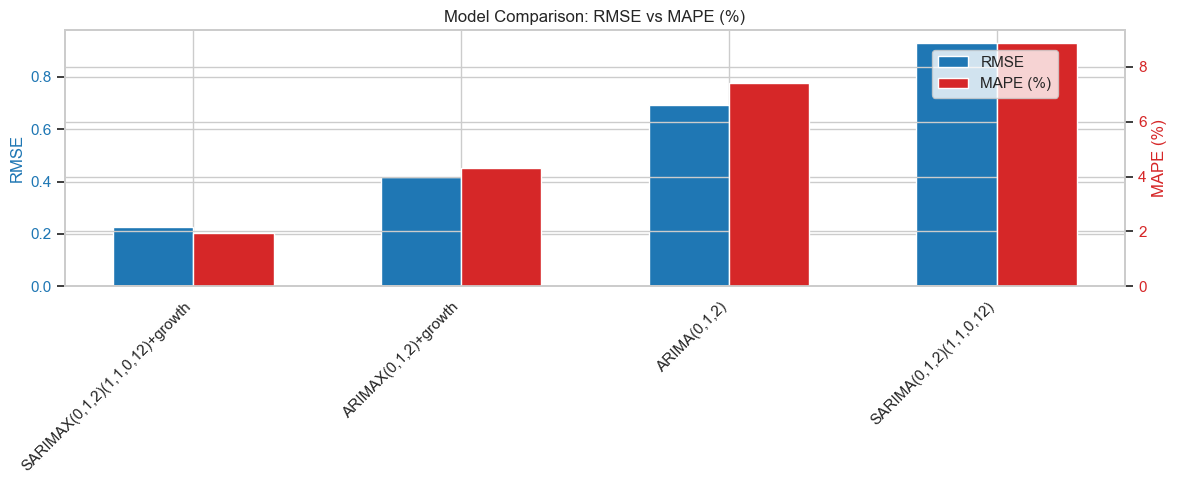

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Models for x-axis
models = performance_df['Model']
x = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(12,5))

# Plot RMSE on left y-axis
color = 'tab:blue'
ax1.bar(x - 0.15, performance_df['RMSE'], width=0.3, color=color, label='RMSE')
ax1.set_ylabel('RMSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

# Plot MAPE on right y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.bar(x + 0.15, performance_df['MAPE (%)'], width=0.3, color=color, label='MAPE (%)')
ax2.set_ylabel('MAPE (%)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title("Model Comparison: RMSE vs MAPE (%)")
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.9))
plt.tight_layout()
plt.show()


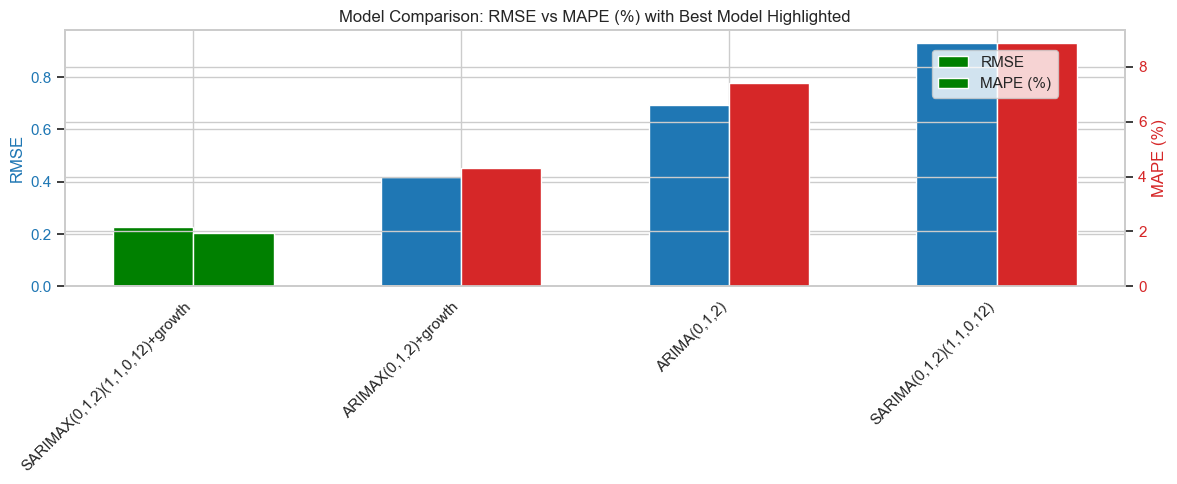

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Identify best model (lowest RMSE)
best_model = performance_df.sort_values(by="RMSE").iloc[0]['Model']

# X-axis
models = performance_df['Model']
x = np.arange(len(models))

# Colors: highlight best model
rmse_colors = ['green' if m == best_model else 'tab:blue' for m in models]
mape_colors = ['green' if m == best_model else 'tab:red' for m in models]

fig, ax1 = plt.subplots(figsize=(12,5))

# RMSE bars
ax1.bar(x - 0.15, performance_df['RMSE'], width=0.3, color=rmse_colors, label='RMSE')
ax1.set_ylabel('RMSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

# MAPE bars
ax2 = ax1.twinx()
ax2.bar(x + 0.15, performance_df['MAPE (%)'], width=0.3, color=mape_colors, label='MAPE (%)')
ax2.set_ylabel('MAPE (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title("Model Comparison: RMSE vs MAPE (%) with Best Model Highlighted")
fig.legend(['RMSE','MAPE (%)', 'Best Model'], loc='upper right', bbox_to_anchor=(0.9,0.9))
plt.tight_layout()
plt.show()


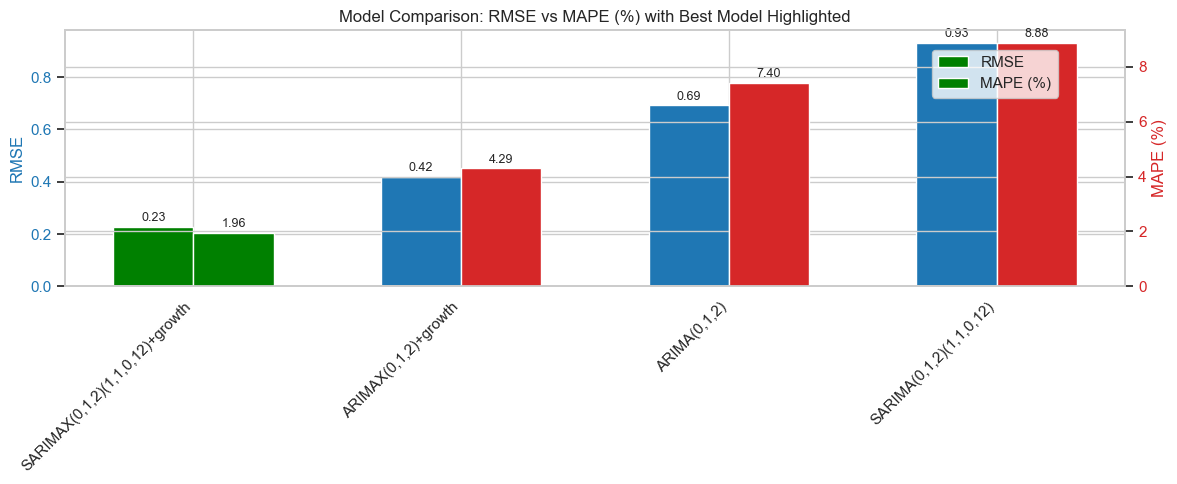

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Identify best model (lowest RMSE)
best_model = performance_df.sort_values(by="RMSE").iloc[0]['Model']

# X-axis
models = performance_df['Model']
x = np.arange(len(models))

# Colors: highlight best model
rmse_colors = ['green' if m == best_model else 'tab:blue' for m in models]
mape_colors = ['green' if m == best_model else 'tab:red' for m in models]

fig, ax1 = plt.subplots(figsize=(12,5))

# RMSE bars
rmse_bars = ax1.bar(x - 0.15, performance_df['RMSE'], width=0.3, color=rmse_colors, label='RMSE')
ax1.set_ylabel('RMSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')

# Annotate RMSE values
for bar in rmse_bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# MAPE bars
ax2 = ax1.twinx()
mape_bars = ax2.bar(x + 0.15, performance_df['MAPE (%)'], width=0.3, color=mape_colors, label='MAPE (%)')
ax2.set_ylabel('MAPE (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Annotate MAPE values
for bar in mape_bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Title and legend
plt.title("Model Comparison: RMSE vs MAPE (%) with Best Model Highlighted")
fig.legend(['RMSE','MAPE (%)', 'Best Model'], loc='upper right', bbox_to_anchor=(0.9,0.9))
plt.tight_layout()
plt.show()
